In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from scipy import stats
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import os
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
water_quality_data = pd.read_csv("/content/water_quality_data .csv")

# Display basic information
print(f"\nDataset dimensions: {water_quality_data.shape}")
print(f"Number of samples: {water_quality_data.shape[0]}")
print(f"Number of features: {water_quality_data.shape[1]}")


Dataset dimensions: (13169, 19)
Number of samples: 13169
Number of features: 19


In [3]:
# Data Cleaning

# Remove duplicates
duplicates = water_quality_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    water_quality_data = water_quality_data.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows.")

Number of duplicate rows: 0


In [4]:
# Check for missing values
missing_values = water_quality_data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])


Missing values in each column:
District       49
Block        1394
Village         2
Latitude        2
Longitude       4
dtype: int64


In [5]:
# Handle missing values
for col in water_quality_data.columns:
    if water_quality_data[col].isnull().sum() > 0:
        # For numeric columns, fill with median
        if pd.api.types.is_numeric_dtype(water_quality_data[col]):
            median_val = water_quality_data[col].median()
            water_quality_data[col] = water_quality_data[col].fillna(median_val)
            print(f"Filled missing values in '{col}' with median: {median_val}")
        else:
            # For categorical/text columns, fill with mode
            mode_val = water_quality_data[col].mode()[0]
            water_quality_data[col] = water_quality_data[col].fillna(mode_val)
            print(f"Filled missing values in '{col}' with mode: {mode_val}")

Filled missing values in 'District' with mode: Erode
Filled missing values in 'Block' with mode: BHUBANESWAR
Filled missing values in 'Village' with mode: Block Office
Filled missing values in 'Latitude' with mode: 32.8281
Filled missing values in 'Longitude' with mode: 74.7417


In [6]:
# Convert latitude and longitude to numeric
if 'Latitude' in water_quality_data.columns and 'Longitude' in water_quality_data.columns:

    water_quality_data['Latitude'] = pd.to_numeric(water_quality_data['Latitude'], errors='coerce')
    water_quality_data['Longitude'] = pd.to_numeric(water_quality_data['Longitude'], errors='coerce')

# Filter out invalid coordinates
geo_data = water_quality_data.dropna(subset=['Latitude', 'Longitude'])
geo_data = geo_data[
    (geo_data['Latitude'] >= 0) &
    (geo_data['Latitude'] <= 90) &
    (geo_data['Longitude'] >= 0) &
    (geo_data['Longitude'] <= 180)
]
print(f"Records with valid coordinates: {geo_data.shape[0]}")

Records with valid coordinates: 11921


In [7]:
# Create water potability feature based on WHO standards
# Define WHO standards for drinking water
who_standards = {
    'pH': (6.5, 8.5),  # pH should be between 6.5 and 8.5
    'TDS': (0, 500),   # TDS should be less than 500 mg/L
    'Cl': (0, 250),    # Chloride should be less than 250 mg/L
    'TH': (0, 300),    # Total Hardness should be less than 300 mg/L
    'Na': (0, 200),    # Sodium should be less than 200 mg/L
    'K': (0, 12)       # Potassium should be less than 12 mg/L
}

In [8]:
# Create potability feature (1 = potable, 0 = non-potable)
def is_potable(row):
    # Check if water quality parameters fall within WHO standards
    if (who_standards['pH'][0] <= row['pH'] <= who_standards['pH'][1] and
        row['TDS'] <= who_standards['TDS'][1] and
        row['Cl'] <= who_standards['Cl'][1] and
        row['TH'] <= who_standards['TH'][1] and
        row['Na'] <= who_standards['Na'][1] and
        row['K'] <= who_standards['K'][1]):
        return 1  # Potable (safe)
    else:
        return 0  # Non-potable (not safe)

water_quality_data['Potable'] = water_quality_data.apply(is_potable, axis=1)

In [9]:
# Display potability distribution
potable_count = water_quality_data['Potable'].value_counts()
print("\nWater Potability Distribution:")
print(f"Potable (Safe): {potable_count.get(1, 0)} samples ({potable_count.get(1, 0)/len(water_quality_data)*100:.2f}%)")
print(f"Non-Potable (Unsafe): {potable_count.get(0, 0)} samples ({potable_count.get(0, 0)/len(water_quality_data)*100:.2f}%)")


Water Potability Distribution:
Potable (Safe): 5768 samples (43.80%)
Non-Potable (Unsafe): 7401 samples (56.20%)


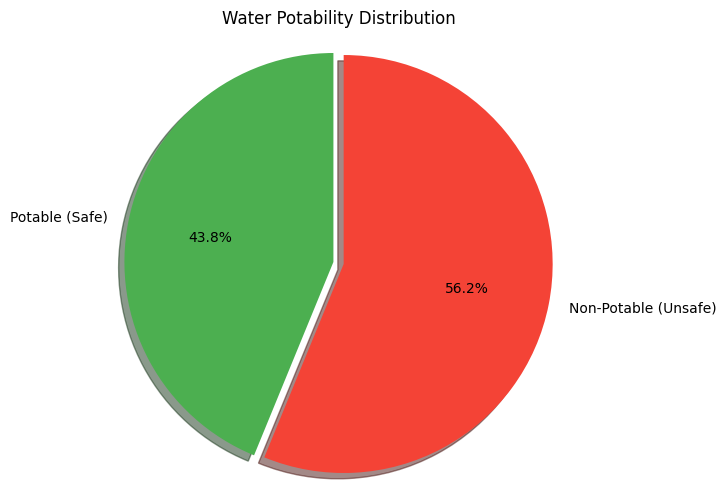

In [10]:
import matplotlib.pyplot as plt

# Count potable and non-potable samples
potable_count = water_quality_data['Potable'].value_counts()

labels = ['Potable (Safe)', 'Non-Potable (Unsafe)']
sizes = [
    potable_count.get(1, 0),
    potable_count.get(0, 0)
]
colors = ['#4CAF50', '#F44336']  # Green for safe, red for unsafe
explode = (0.05, 0)  # Slightly explode the 'Potable' slice

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%',
        startangle=90, shadow=True)
plt.title('Water Potability Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()


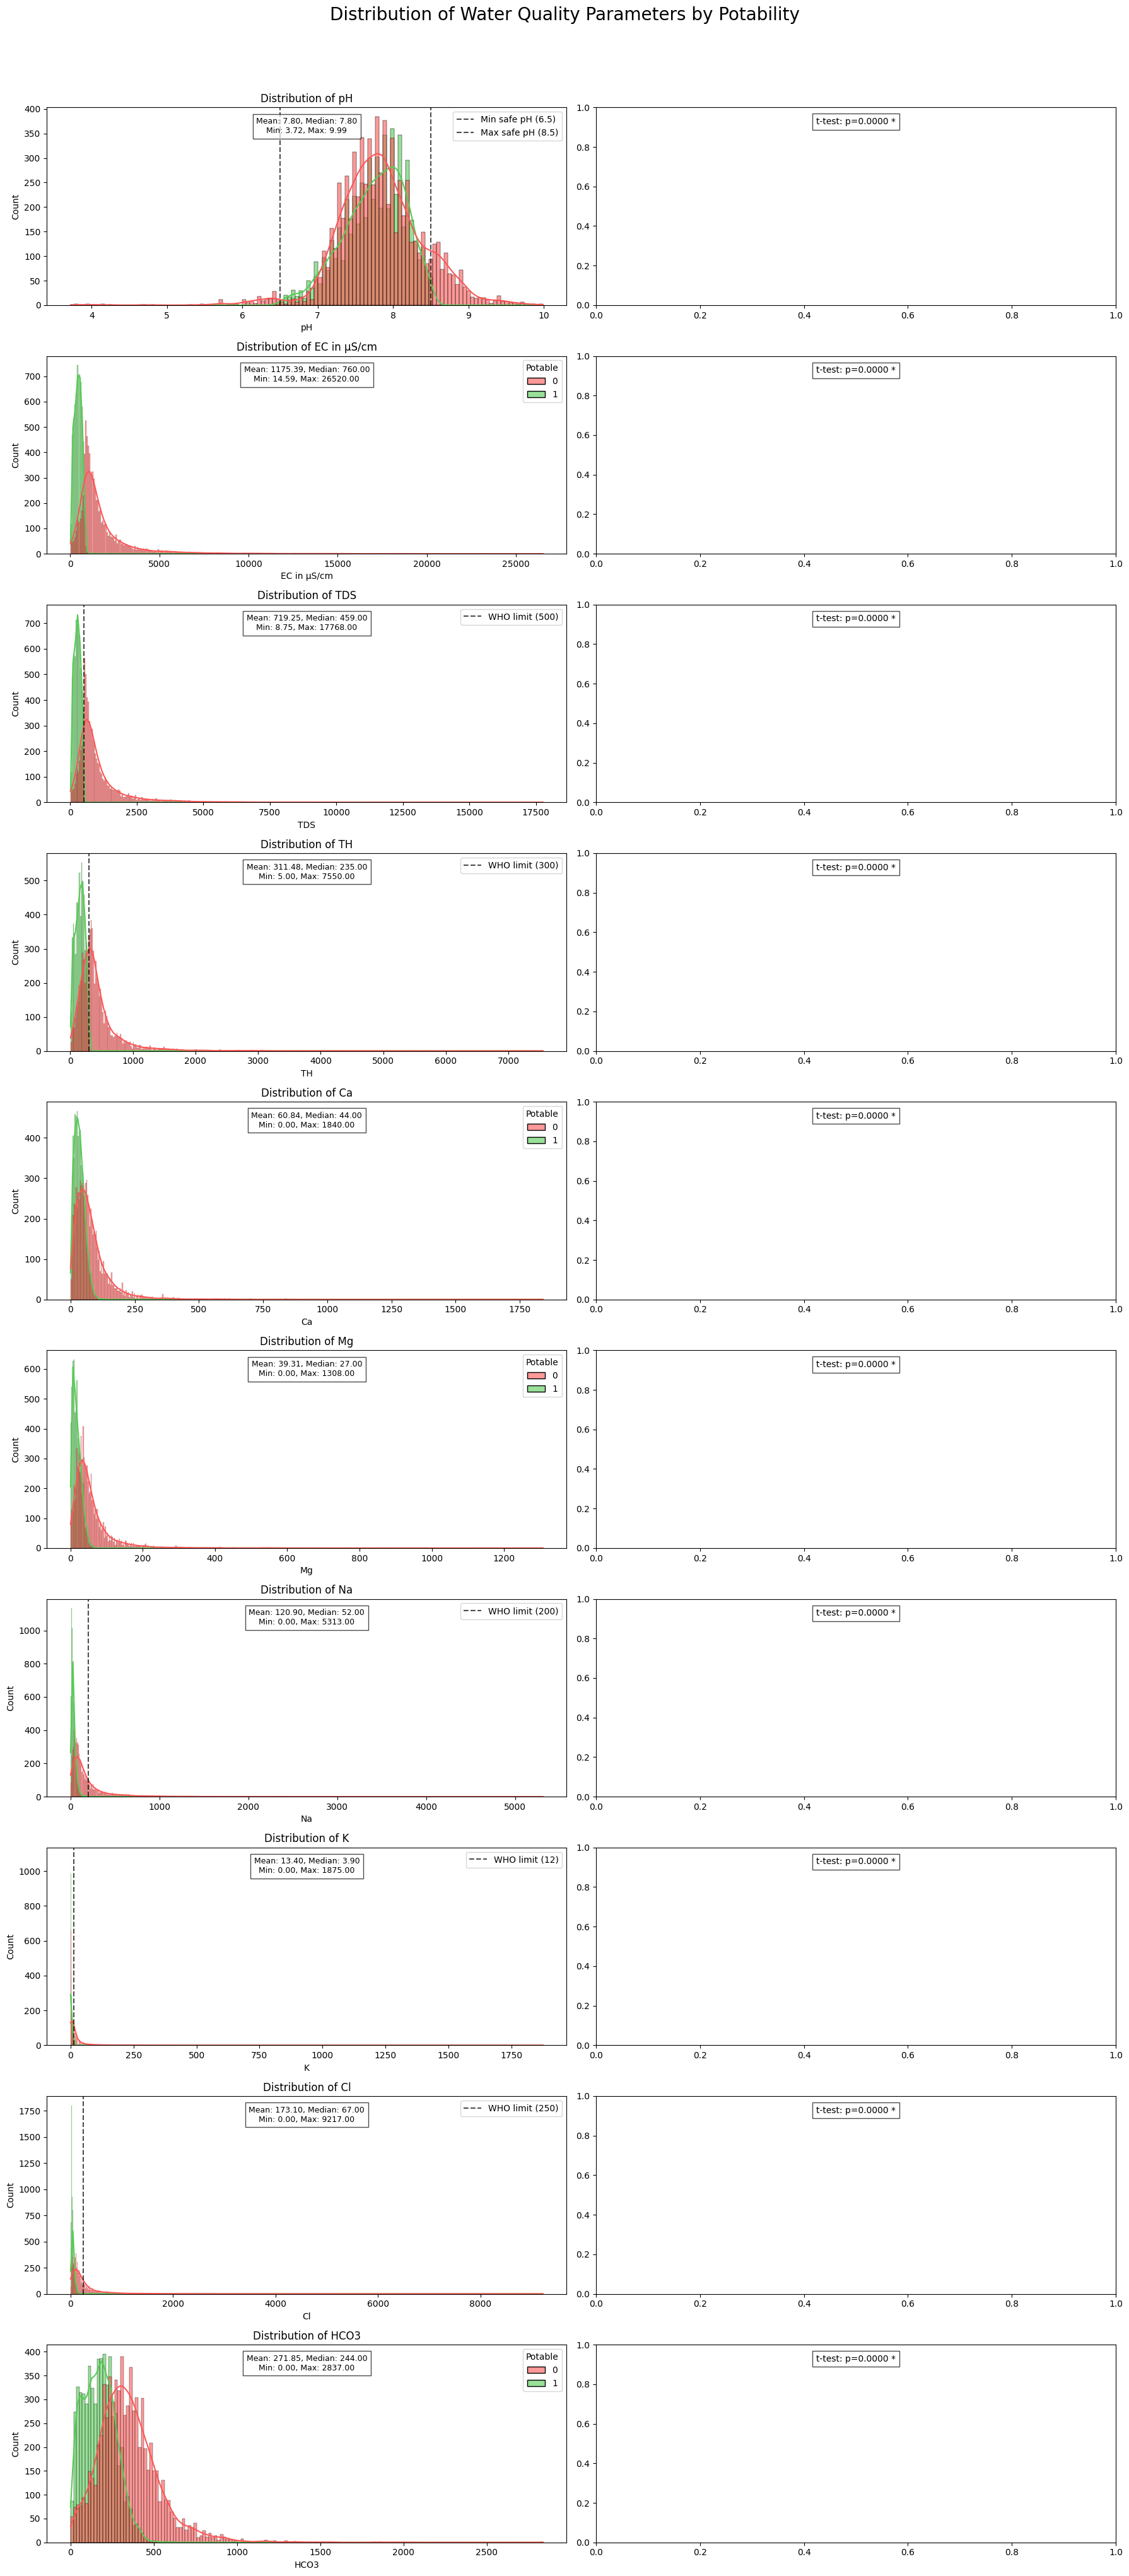

In [11]:
# 1. Distribution of key water quality parameters
water_params = ['pH', 'EC in μS/cm', 'TDS', 'TH', 'Ca', 'Mg', 'Na', 'K', 'Cl', 'HCO3']

fig, axes = plt.subplots(len(water_params), 2, figsize=(18, 4*len(water_params)))
fig.suptitle('Distribution of Water Quality Parameters by Potability', fontsize=20, y=1.02)

for i, param in enumerate(water_params):
    if param in water_quality_data.columns:
        # Left plot: Distribution with KDE
        sns.histplot(data=water_quality_data, x=param, kde=True, ax=axes[i, 0],
                     hue='Potable', palette=['#FF5555', '#55CC55'], alpha=0.6)

        # Add vertical lines for thresholds if applicable
        if param == 'pH':
            axes[i, 0].axvline(x=6.5, color='black', linestyle='--', alpha=0.7, label='Min safe pH (6.5)')
            axes[i, 0].axvline(x=8.5, color='black', linestyle='--', alpha=0.7, label='Max safe pH (8.5)')
            axes[i, 0].legend()
        elif param in who_standards:
            upper_limit = who_standards[param][1]
            axes[i, 0].axvline(x=upper_limit, color='black', linestyle='--', alpha=0.7,
                             label=f'WHO limit ({upper_limit})')
            axes[i, 0].legend()

        # Add statistics to the plot
        stats_text = (f"Mean: {water_quality_data[param].mean():.2f}, "
                    f"Median: {water_quality_data[param].median():.2f}\n"
                    f"Min: {water_quality_data[param].min():.2f}, "
                    f"Max: {water_quality_data[param].max():.2f}")
        axes[i, 0].text(0.5, 0.95, stats_text, transform=axes[i, 0].transAxes,
                     fontsize=9, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.7))

        axes[i, 0].set_title(f'Distribution of {param}')

        # Add significance test
        potable_values = water_quality_data[water_quality_data['Potable']==1][param]
        non_potable_values = water_quality_data[water_quality_data['Potable']==0][param]

        t_stat, p_val = stats.ttest_ind(potable_values, non_potable_values, equal_var=False)
        sig_text = f"t-test: p={p_val:.4f}" + (" *" if p_val < 0.05 else "")
        axes[i, 1].text(0.5, 0.95, sig_text, transform=axes[i, 1].transAxes,
                      fontsize=10, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()

In [12]:
# 2. Correlation Analysis
# Select only numeric columns for correlation
numeric_cols = water_quality_data.select_dtypes(include=[np.number]).columns.tolist()
correlation_data = water_quality_data[numeric_cols]

# Calculate correlation matrix
corr_matrix = correlation_data.corr()
print(corr_matrix)

             Unnamed: 0    S. No.  Latitude  Longitude  Year        pH  \
Unnamed: 0     1.000000  0.999916  0.007690   0.012093   NaN  0.011846   
S. No.         0.999916  1.000000  0.007792   0.012103   NaN  0.011520   
Latitude       0.007690  0.007792  1.000000  -0.000148   NaN -0.002710   
Longitude      0.012093  0.012103 -0.000148   1.000000   NaN -0.001453   
Year                NaN       NaN       NaN        NaN   NaN       NaN   
pH             0.011846  0.011520 -0.002710  -0.001453   NaN  1.000000   
EC in μS/cm   -0.088754 -0.087308 -0.004501  -0.002633   NaN  0.048537   
HCO3          -0.086783 -0.085423 -0.002892  -0.004852   NaN  0.068945   
Cl            -0.075263 -0.074260 -0.003205  -0.001402   NaN  0.006508   
TH            -0.056066 -0.055358 -0.002775   0.001304   NaN -0.046209   
Ca            -0.075414 -0.074823 -0.000898   0.000245   NaN -0.130869   
Mg            -0.026667 -0.025902 -0.003794   0.001528   NaN  0.031186   
Na            -0.104824 -0.103130 -0.0

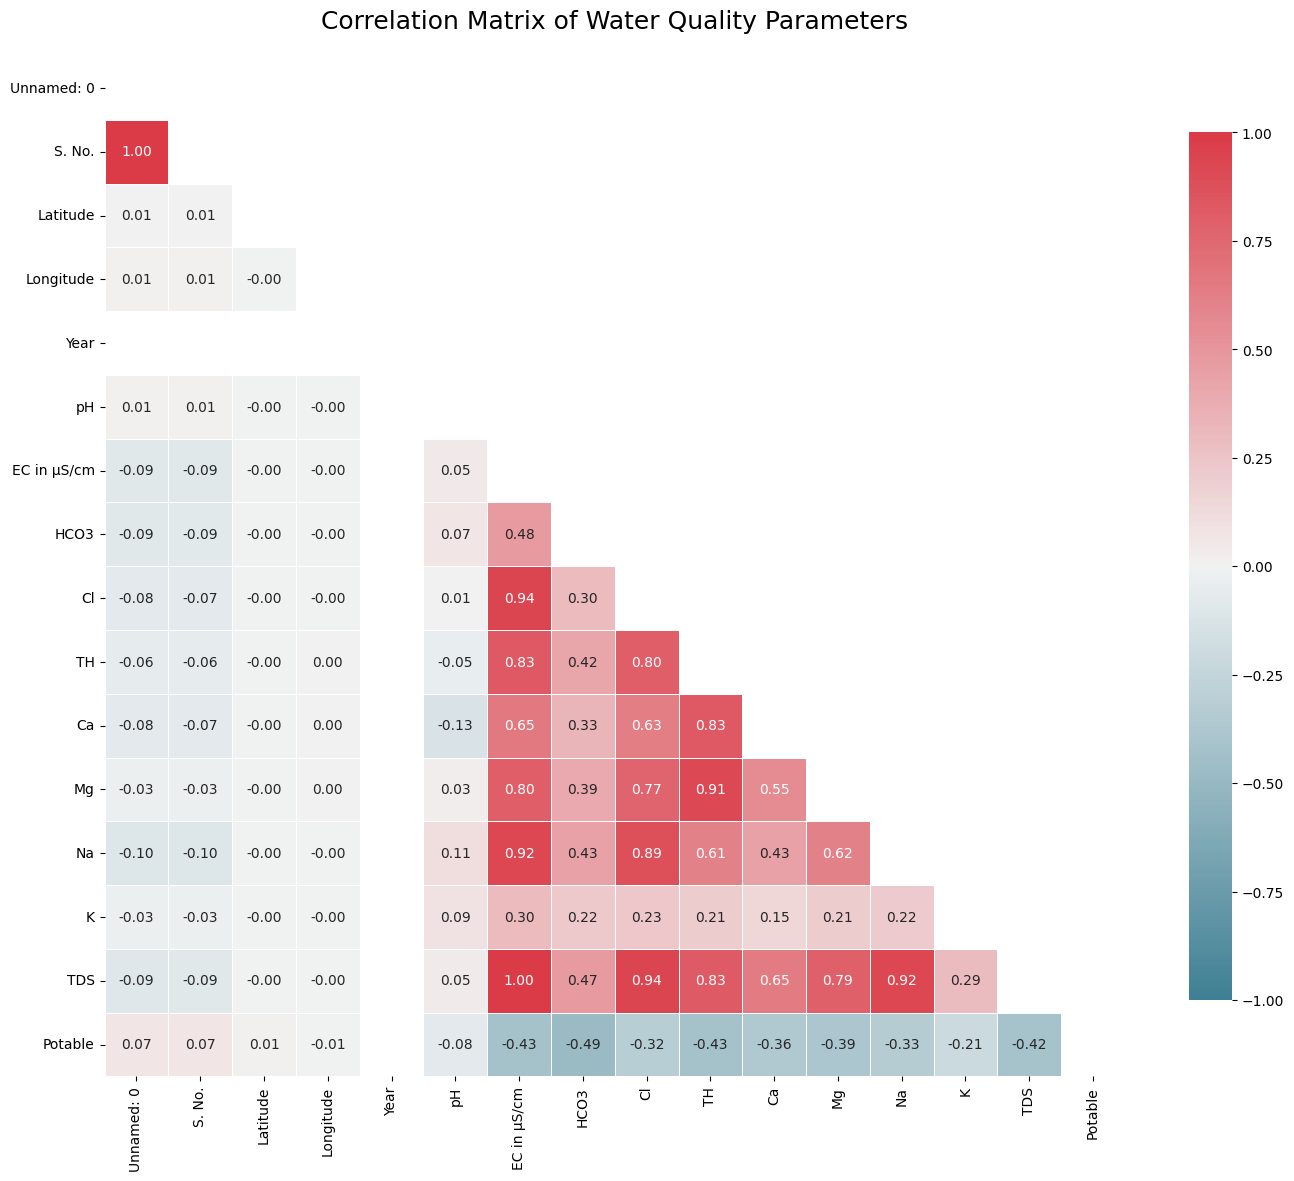

In [13]:
# Create a beautiful heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                     square=True, linewidths=.5, annot=True, fmt='.2f', cbar_kws={"shrink": .8})

heatmap.set_title('Correlation Matrix of Water Quality Parameters', fontsize=18, pad=20)
plt.tight_layout()

Text(0.5, 1.02, 'Pairplot of Key Water Quality Parameters')

<Figure size 1600x1400 with 0 Axes>

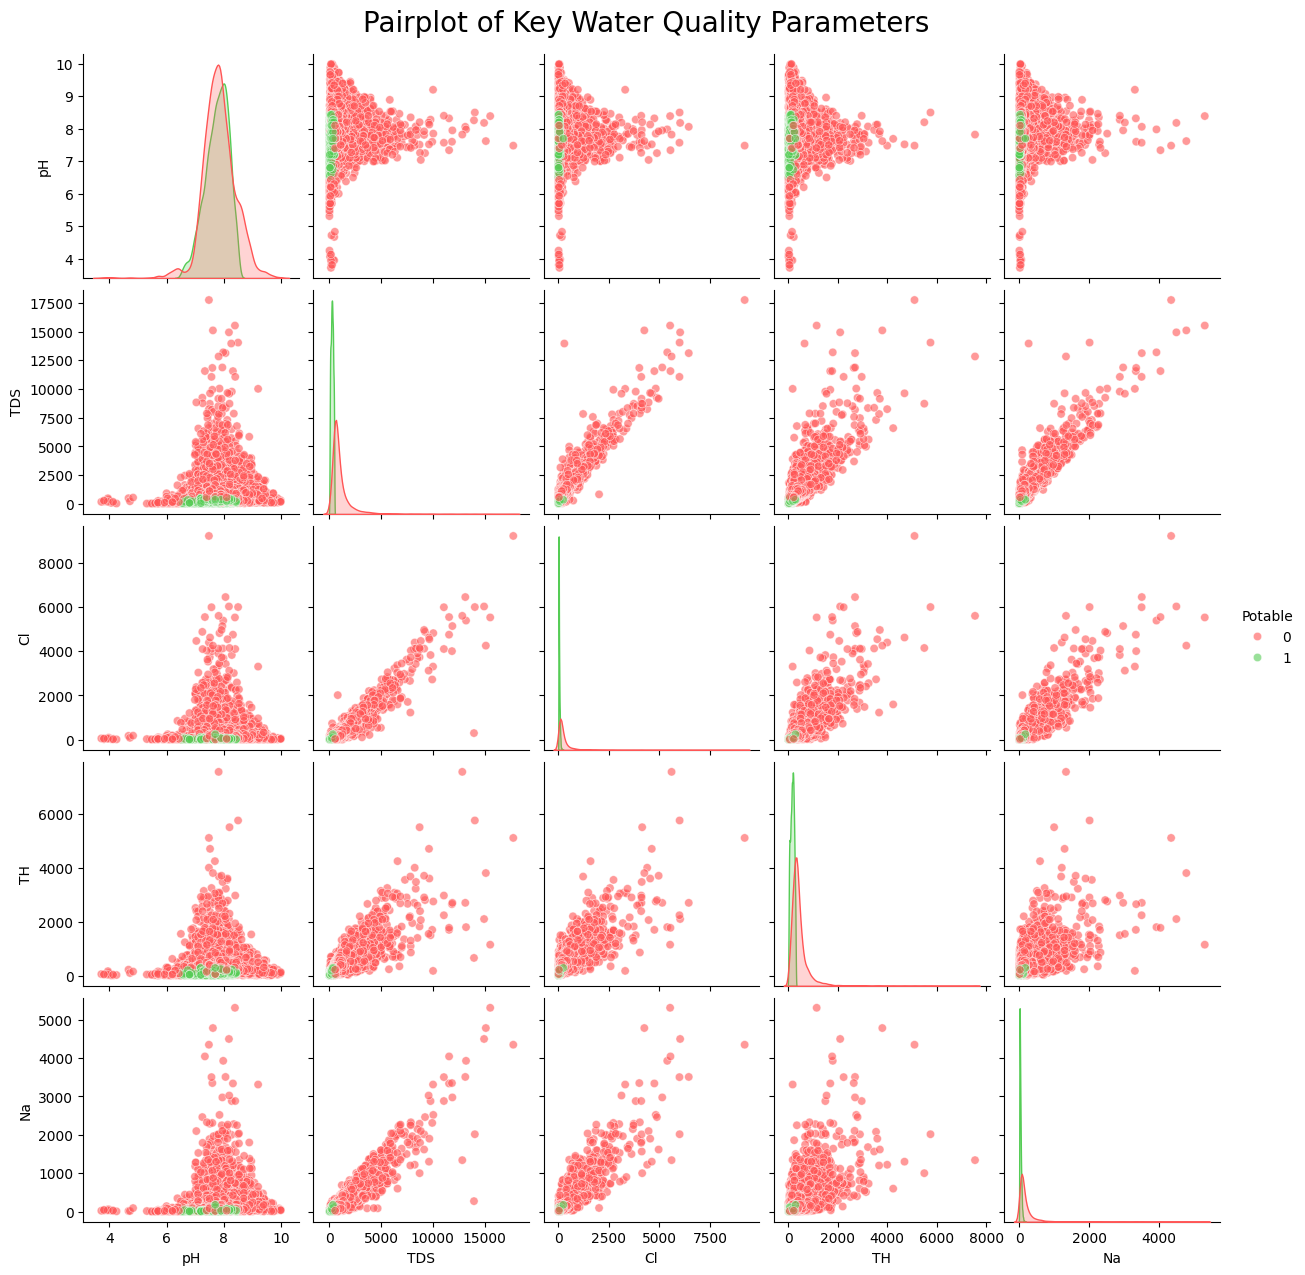

In [14]:
# 3. Create a detailed pairplot for the most important parameters
key_params = ['pH', 'TDS', 'Cl', 'TH', 'Na', 'Potable']
plt.figure(figsize=(16, 14))
pairplot = sns.pairplot(water_quality_data[key_params], hue='Potable', palette=['#FF5555', '#55CC55'],
                      diag_kind='kde', plot_kws={'alpha': 0.6})
pairplot.fig.suptitle('Pairplot of Key Water Quality Parameters', fontsize=20, y=1.02)

In [15]:
# 4. Principal Component Analysis (PCA) for dimensionality reduction and visualization

# Select features for PCA (numerical columns except Potable)
feature_cols = [col for col in numeric_cols if col not in ['Potable', 'S. No.']]
X = water_quality_data[feature_cols].copy()  # Make a copy to avoid modifying original data

# Check for missing values before PCA
missing_vals = X.isnull().sum()
missing_cols = missing_vals[missing_vals > 0]

if len(missing_cols) > 0:
    print("Missing values by column:")
    print(missing_cols)
    print(f"Total missing values: {X.isnull().sum().sum()}")

    print("Handling missing values for PCA...")
    # Fill missing values with median for each column
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            median_val = X[col].median()
            X[col].fillna(median_val, inplace=True)
            print(f"  - Filled {X[col].isnull().sum()} missing values in '{col}' with median: {median_val:.2f}")

    # Double-check that all missing values are handled
    remaining_missing = X.isnull().sum().sum()
    if remaining_missing > 0:
        print(f"WARNING: Still found {remaining_missing} missing values after imputation")
        # If there are still missing values, drop those rows as a last resort
        X.dropna(inplace=True)
        print(f"  - Dropped rows with missing values. Remaining rows: {len(X)}")
    else:
        print("All missing values successfully handled.")
else:
    print("No missing values found in the feature data.")

Missing values by column:
Latitude     1246
Longitude    1245
dtype: int64
Total missing values: 2491
Handling missing values for PCA...
  - Filled 0 missing values in 'Latitude' with median: 22.47
  - Filled 0 missing values in 'Longitude' with median: 78.31
All missing values successfully handled.


In [16]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Apply PCA with 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [18]:
# Create a dataframe with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Potable'] = water_quality_data['Potable'].values

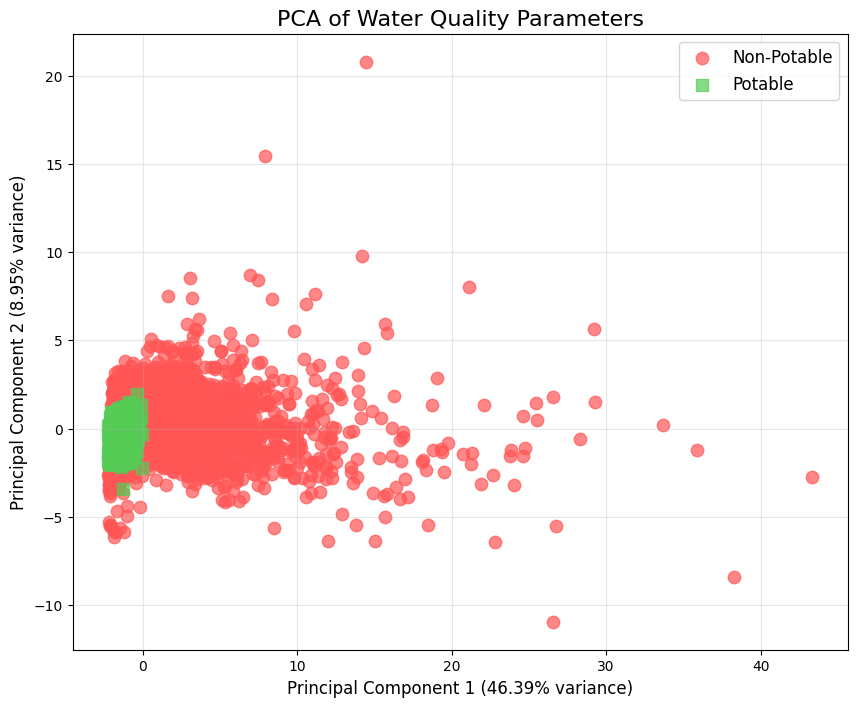

In [19]:
# Create a better PCA visualization
plt.figure(figsize=(10, 8))
colors = ['#FF5555', '#55CC55']
markers = ['o', 's']
labels = ['Non-Potable', 'Potable']

for i, label in enumerate([0, 1]):
    plt.scatter(pca_df[pca_df['Potable'] == label]['PC1'],
                pca_df[pca_df['Potable'] == label]['PC2'],
                c=colors[i], marker=markers[i], alpha=0.7, s=80,
                label=labels[i])

plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('PCA of Water Quality Parameters', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

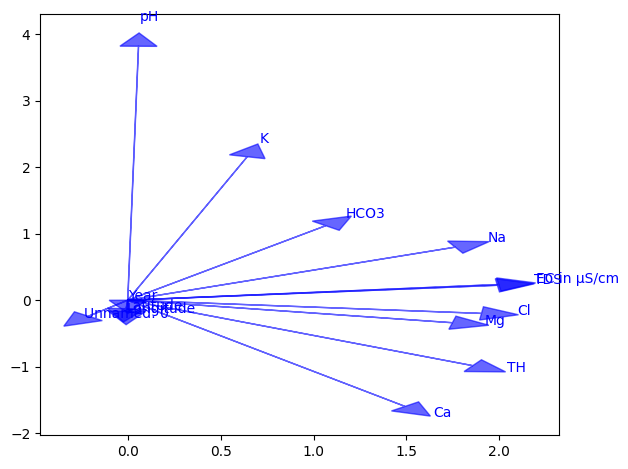

In [20]:
# Add loading vectors
feature_vectors = pca.components_.T
feature_names = feature_cols

# Scale the feature vectors for visualization
scaling_factor = 5
for i, feature in enumerate(feature_names):
    plt.arrow(0, 0,
              feature_vectors[i, 0] * scaling_factor,
              feature_vectors[i, 1] * scaling_factor,
              head_width=0.2, head_length=0.2, fc='blue', ec='blue', alpha=0.6)
    plt.text(feature_vectors[i, 0] * scaling_factor * 1.1,
             feature_vectors[i, 1] * scaling_factor * 1.1,
             feature,
             color='blue', fontsize=10)

plt.tight_layout()

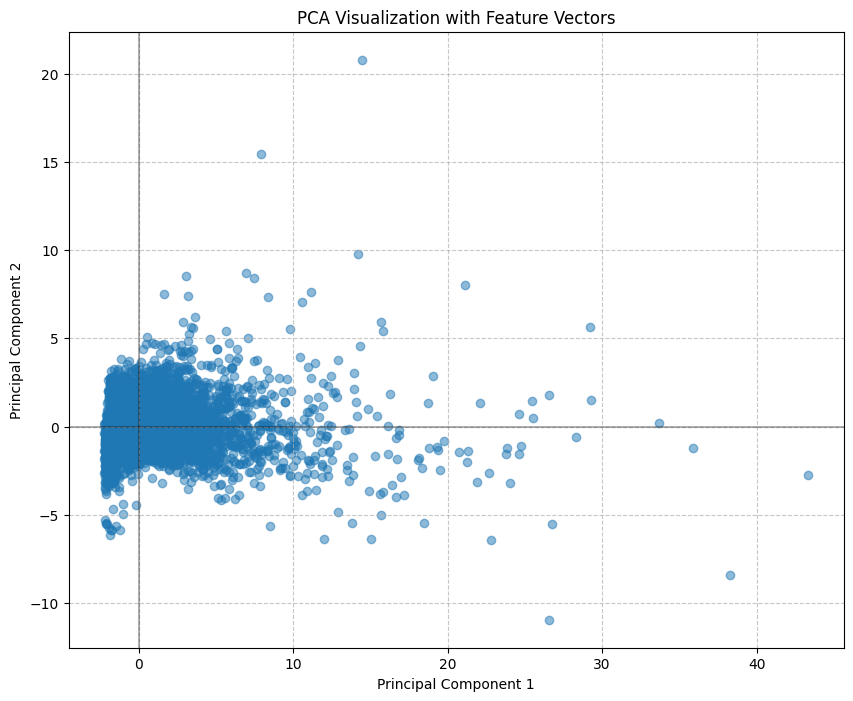

In [21]:
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)  # Add data points
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization with Feature Vectors')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

In [22]:
# Also create a 3D PCA plot for more dimensions
pca3d = PCA(n_components=3)
X_pca3d = pca3d.fit_transform(X_scaled)

pca3d_df = pd.DataFrame(data=X_pca3d, columns=['PC1', 'PC2', 'PC3'])
pca3d_df['Potable'] = water_quality_data['Potable'].values

In [23]:
# Create a 3D PCA plot using Plotly
fig = px.scatter_3d(
    pca3d_df, x='PC1', y='PC2', z='PC3', color='Potable',
    color_discrete_map={0: '#FF5555', 1: '#55CC55'},
    labels={'Potable': 'Water Potability'},
    title='3D PCA of Water Quality Parameters',
    opacity=0.7
)

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title=f'PC1 ({pca3d.explained_variance_ratio_[0]:.2%})',
        yaxis_title=f'PC2 ({pca3d.explained_variance_ratio_[1]:.2%})',
        zaxis_title=f'PC3 ({pca3d.explained_variance_ratio_[2]:.2%})'
    ),
    legend=dict(
        title='Potability',
        itemsizing='constant',
        font=dict(size=14)
    ),
    title_font_size=20
)



Creating water potability distribution map...
Could not load India's geographical data, plotting points only.


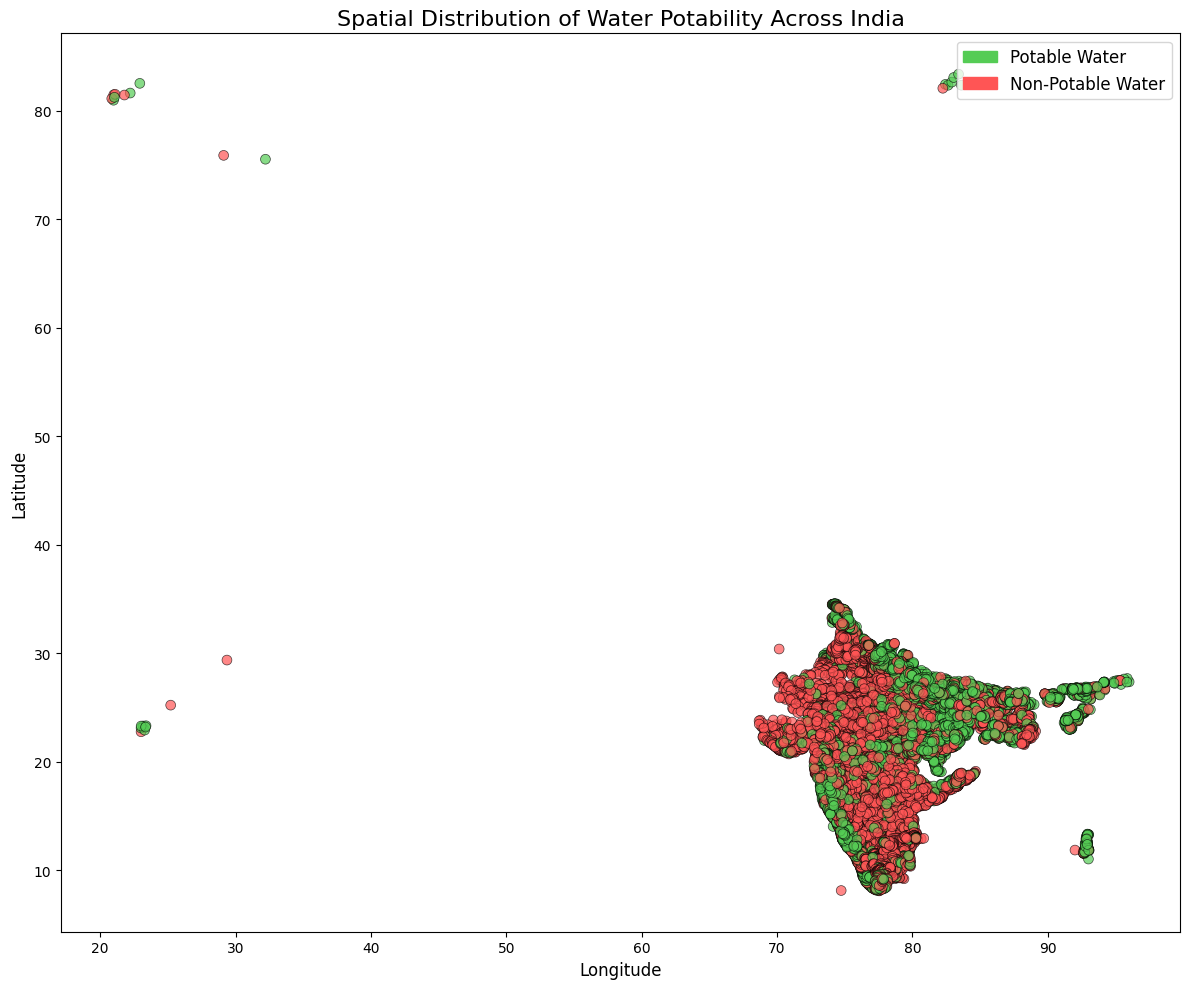

In [24]:
# Convert the data to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    geo_data,
    geometry=gpd.points_from_xy(geo_data.Longitude, geo_data.Latitude),
    crs="EPSG:4326"  # WGS84 coordinate system
)

# Create a spatial distribution map of water potability
gdf['Potable'] = gdf.apply(is_potable, axis=1)

# 1. Create a map showing potability across India
print("\nCreating water potability distribution map...")
fig, ax = plt.subplots(figsize=(12, 10))

# Define custom colors for potability
colors = ['#FF5555', '#55CC55']  # Red for non-potable, green for potable
cmap = ListedColormap(colors)

# Plot the points
scatter = ax.scatter(gdf.geometry.x, gdf.geometry.y,
                    c=gdf['Potable'], cmap=cmap,
                    s=50, alpha=0.7, edgecolor='k', linewidth=0.5)

# Add state boundaries from a natural earth dataset if available
try:
    # Try to load a simplified version of India's states
    india_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    india_states = india_states[india_states['name'] == 'India']
    india_states.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.8)
except:
    print("Could not load India's geographical data, plotting points only.")

# Create a legend
potable_patch = mpatches.Patch(color=colors[1], label='Potable Water')
non_potable_patch = mpatches.Patch(color=colors[0], label='Non-Potable Water')
ax.legend(handles=[potable_patch, non_potable_patch], loc='upper right', fontsize=12)

# Set plot title and labels
ax.set_title('Spatial Distribution of Water Potability Across India', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Save the plot
plt.tight_layout()

In [25]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.1 MB/s eta 0:00:00


Filtered dataset to 11489 data points after removing outliers


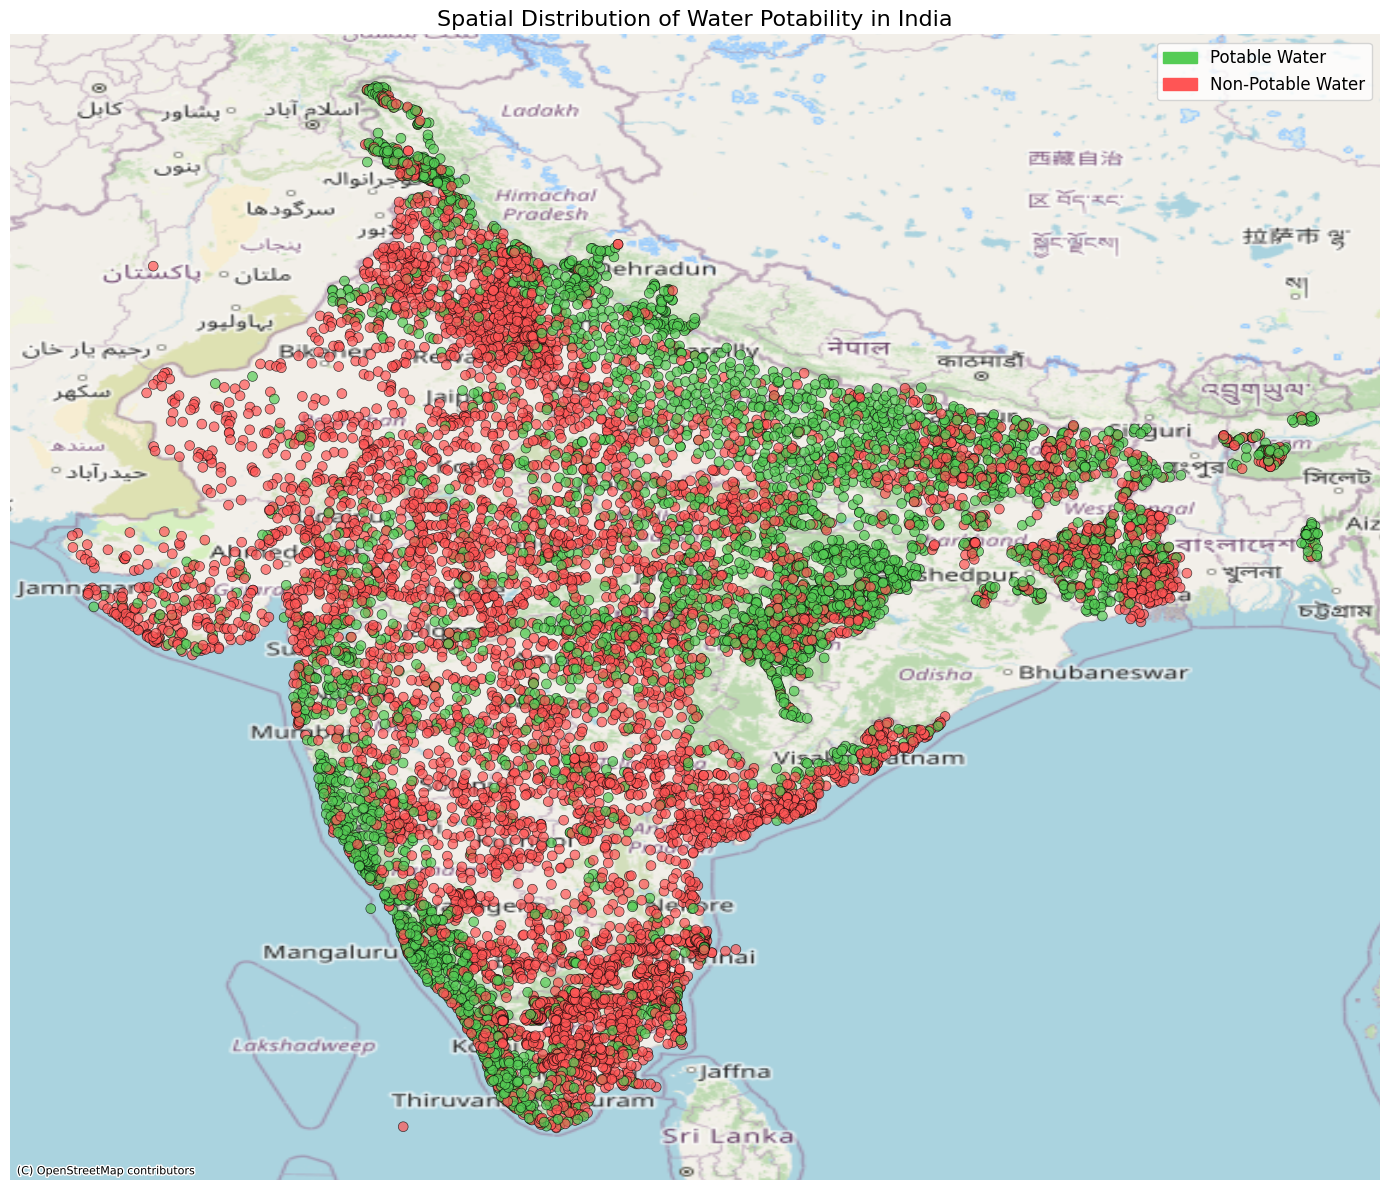

In [26]:
# Import necessary libraries if not already imported
import contextily as ctx
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Convert the data to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    geo_data,
    geometry=gpd.points_from_xy(geo_data.Longitude, geo_data.Latitude),
    crs="EPSG:4326"  # WGS84 coordinate system
)

# Create a potability column
gdf['Potable'] = gdf.apply(is_potable, axis=1)

# Remove outliers based on India's approximate boundaries
# India's bounding box (approximately): lon (68, 97.5), lat (6, 37.5)
india_bounds = (68, 6, 97.5, 37.5)  # (min_lon, min_lat, max_lon, max_lat)

# Filter data points within India (removing outliers)
gdf_filtered = gdf[(gdf.geometry.x >= india_bounds[0]) &
                   (gdf.geometry.x <= india_bounds[2]) &
                   (gdf.geometry.y >= india_bounds[1]) &
                   (gdf.geometry.y <= india_bounds[3])]

# Further remove outliers using IQR method on lat/long
def remove_outliers_iqr(df, col, k=1.5):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Apply IQR outlier removal to longitude and latitude
gdf_filtered = remove_outliers_iqr(gdf_filtered, 'Longitude')
gdf_filtered = remove_outliers_iqr(gdf_filtered, 'Latitude')

print(f"Filtered dataset to {len(gdf_filtered)} data points after removing outliers")

# Create map for India
fig, ax = plt.subplots(figsize=(14, 12))

# Convert to Web Mercator for contextily
gdf_web = gdf_filtered.to_crs(epsg=3857)

# Define custom colors for potability
colors = ['#FF5555', '#55CC55']  # Red for non-potable, green for potable
cmap = ListedColormap(colors)

# Plot data points
scatter = ax.scatter(gdf_web.geometry.x, gdf_web.geometry.y,
                    c=gdf_web['Potable'], cmap=cmap,
                    s=50, alpha=0.7, edgecolor='k', linewidth=0.5)

# Add contextily basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Create a legend
potable_patch = mpatches.Patch(color=colors[1], label='Potable Water')
non_potable_patch = mpatches.Patch(color=colors[0], label='Non-Potable Water')
ax.legend(handles=[potable_patch, non_potable_patch], loc='upper right', fontsize=12)

# Set plot title
ax.set_title('Spatial Distribution of Water Potability in India', fontsize=16)

# Remove axis labels as they're not meaningful in Web Mercator
ax.set_axis_off()

# Save the plot
plt.tight_layout()

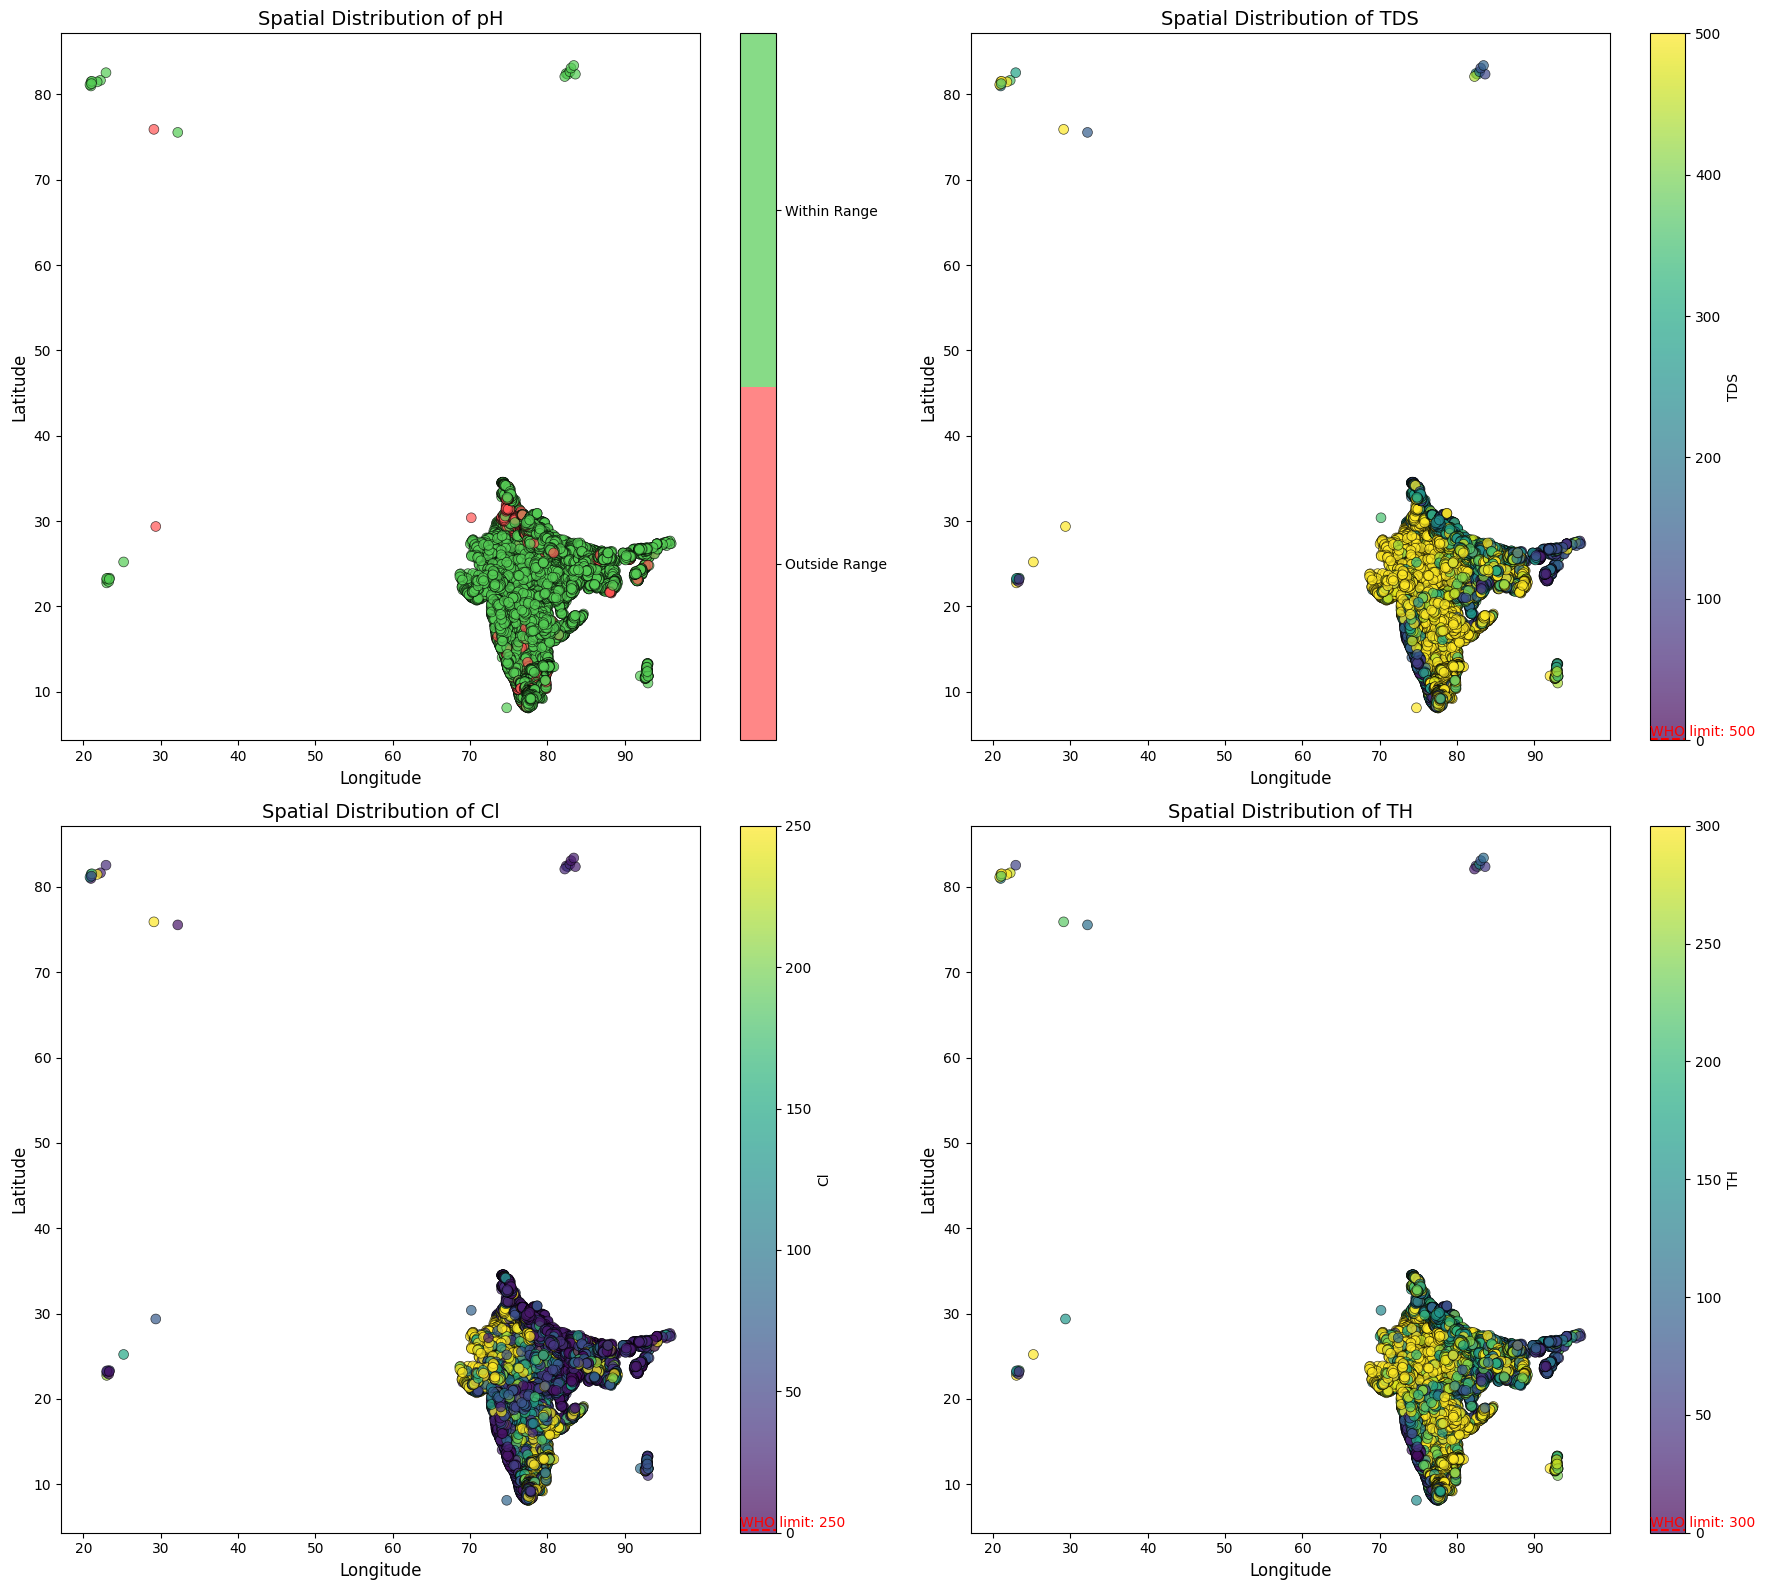

In [27]:
# 2. Create multiple maps for different parameters
params_to_map = ['pH', 'TDS', 'Cl', 'TH']

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

for i, param in enumerate(params_to_map):
    # Define color map based on parameter thresholds
    if param == 'pH':
        # For pH, we want to show whether it's within the acceptable range (6.5-8.5)
        gdf['pH_status'] = gdf['pH'].apply(lambda x: 1 if 6.5 <= x <= 8.5 else 0)
        scatter = axes[i].scatter(gdf.geometry.x, gdf.geometry.y,
                                 c=gdf['pH_status'], cmap=ListedColormap(['#FF5555', '#55CC55']),
                                 s=50, alpha=0.7, edgecolor='k', linewidth=0.5)
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[i], ticks=[0.25, 0.75])
        cbar.ax.set_yticklabels(['Outside Range', 'Within Range'])
    else:
        # For other parameters, use a continuous color map to show concentration
        vmax = who_standards.get(param, (0, gdf[param].quantile(0.95)))[1]  # Use 95th percentile if no standard
        scatter = axes[i].scatter(gdf.geometry.x, gdf.geometry.y,
                                 c=gdf[param], cmap='viridis',
                                 s=50, alpha=0.7, edgecolor='k', linewidth=0.5,
                                 vmin=0, vmax=vmax)
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[i])
        cbar.set_label(param)

        # Add threshold line to colorbar if available
        if param in who_standards:
            threshold = who_standards[param][1]
            cbar.ax.axhline(y=threshold/vmax, color='r', linestyle='--')
            cbar.ax.text(0, threshold/vmax, f"WHO limit: {threshold}",
                        va='bottom', ha='left', color='red', fontsize=10)

    # Set plot title
    axes[i].set_title(f'Spatial Distribution of {param}', fontsize=14)
    axes[i].set_xlabel('Longitude', fontsize=12)
    axes[i].set_ylabel('Latitude', fontsize=12)

# Save the plot
plt.tight_layout()

In [28]:
"""
AquaSense: AI-Driven Well Insights
Model Training and Saving
==========================
This script trains XGBoost and Random Forest models for water potability prediction
and saves them for use in the dashboard.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import os
import joblib

# Create directory for models if it doesn't exist
os.makedirs("ai_models", exist_ok=True)

In [30]:

# Load data

water_quality_data = pd.read_csv("/content/water_quality_data .csv")

In [31]:
# Create water potability feature based on WHO standards

# Define WHO standards for drinking water
who_standards = {
    'pH': (6.5, 8.5),  # pH should be between 6.5 and 8.5
    'TDS': (0, 500),   # TDS should be less than 500 mg/L
    'Cl': (0, 250),    # Chloride should be less than 250 mg/L
    'TH': (0, 300),    # Total Hardness should be less than 300 mg/L
    'Na': (0, 200),    # Sodium should be less than 200 mg/L
    'K': (0, 12)       # Potassium should be less than 12 mg/L
}

# Create potability feature (1 = potable, 0 = non-potable)
def is_potable(row):
    # Check if water quality parameters fall within WHO standards
    if (who_standards['pH'][0] <= row['pH'] <= who_standards['pH'][1] and
        row['TDS'] <= who_standards['TDS'][1] and
        row['Cl'] <= who_standards['Cl'][1] and
        row['TH'] <= who_standards['TH'][1] and
        row['Na'] <= who_standards['Na'][1] and
        row['K'] <= who_standards['K'][1]):
        return 1  # Potable (safe)
    else:
        return 0  # Non-potable (not safe)

water_quality_data['Potable'] = water_quality_data.apply(is_potable, axis=1)

# Display potability distribution
potable_count = water_quality_data['Potable'].value_counts()
print("\nWater Potability Distribution:")
print(f"Potable (Safe): {potable_count.get(1, 0)} samples ({potable_count.get(1, 0)/len(water_quality_data)*100:.2f}%)")
print(f"Non-Potable (Unsafe): {potable_count.get(0, 0)} samples ({potable_count.get(0, 0)/len(water_quality_data)*100:.2f}%)")


Water Potability Distribution:
Potable (Safe): 5768 samples (43.80%)
Non-Potable (Unsafe): 7401 samples (56.20%)


In [32]:
# Prepare the data for modeling
print("\nPreparing data for modeling...")
feature_cols = ['pH', 'EC in μS/cm', 'TDS', 'TH', 'Ca', 'Mg', 'Na', 'K', 'Cl', 'HCO3']
X = water_quality_data[feature_cols]
y = water_quality_data['Potable']


Preparing data for modeling...


In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 9218 samples
Testing set size: 3951 samples


In [34]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
joblib.dump(scaler, "standard_scaler.pkl")
print("Saved StandardScaler to ai_models/standard_scaler.pkl")

Saved StandardScaler to ai_models/standard_scaler.pkl


In [35]:
import joblib


In [36]:
# 1. XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [37]:
# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\nXGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")

# Save the XGBoost model
joblib.dump(xgb_model, "xgb_water_quality_model.pkl")
print("Saved XGBoost model to ai_models/xgb_water_quality_model.pkl")


XGBoost Model Evaluation:
Accuracy: 0.9939
Precision: 0.9897
Recall: 0.9965
F1 Score: 0.9931
Saved XGBoost model to ai_models/xgb_water_quality_model.pkl


In [38]:
# 2. Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [39]:
# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")

# Save the Random Forest model
joblib.dump(rf_model, "rf_water_quality_model.pkl")
print("Saved Random Forest model to ai_models/rf_water_quality_model.pkl")


Random Forest Model Evaluation:
Accuracy: 0.9997
Precision: 0.9994
Recall: 1.0000
F1 Score: 0.9997
Saved Random Forest model to ai_models/rf_water_quality_model.pkl


In [40]:
# Feature Importance Analysis
print("\nAnalyzing feature importance...")
# Get feature importance from both models
xgb_importance = xgb_model.feature_importances_
rf_importance = rf_model.feature_importances_

# Debug: Print lengths to identify the mismatch
print(f"Length of feature_cols: {len(feature_cols)}")
print(f"Length of XGBoost importance: {len(xgb_importance)}")
print(f"Length of Random Forest importance: {len(rf_importance)}")

# Make sure all arrays are the same length
if len(feature_cols) == len(xgb_importance) == len(rf_importance):
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'XGBoost Importance': xgb_importance,
        'Random Forest Importance': rf_importance
    })

    # Sort by XGBoost importance
    feature_importance = feature_importance.sort_values('XGBoost Importance', ascending=False)
    print("\nFeature importance ranking (XGBoost):")
    print(feature_importance[['Feature', 'XGBoost Importance']].to_string(index=False))

    print("\nFeature importance ranking (Random Forest):")
    print(feature_importance.sort_values('Random Forest Importance', ascending=False)[['Feature', 'Random Forest Importance']].to_string(index=False))
else:
    # Alternative approach if lengths don't match
    print("\nWARNING: Feature length mismatch. Using a different approach to display feature importance.")

    # Display XGBoost feature importance
    if len(feature_cols) == len(xgb_importance):
        xgb_importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'XGBoost Importance': xgb_importance
        }).sort_values('XGBoost Importance', ascending=False)
        print("\nFeature importance ranking (XGBoost):")
        print(xgb_importance_df.to_string(index=False))
    else:
        print("\nCannot display XGBoost feature importance due to length mismatch.")

    # Display Random Forest feature importance
    if len(feature_cols) == len(rf_importance):
        rf_importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Random Forest Importance': rf_importance
        }).sort_values('Random Forest Importance', ascending=False)
        print("\nFeature importance ranking (Random Forest):")
        print(rf_importance_df.to_string(index=False))
    else:
        print("\nCannot display Random Forest feature importance due to length mismatch.")

print("\nModel training and saving completed successfully!")
print("You can now run the dashboard with: streamlit run aquasense_dashboard.py")


Analyzing feature importance...
Length of feature_cols: 10
Length of XGBoost importance: 10
Length of Random Forest importance: 10

Feature importance ranking (XGBoost):
    Feature  XGBoost Importance
        TDS            0.633356
          K            0.111102
EC in μS/cm            0.088070
         TH            0.079932
         pH            0.072584
         Cl            0.004671
         Na            0.003107
         Ca            0.002822
       HCO3            0.002509
         Mg            0.001846

Feature importance ranking (Random Forest):
    Feature  Random Forest Importance
        TDS                  0.275302
EC in μS/cm                  0.205456
          K                  0.128657
         TH                  0.111631
         pH                  0.101442
         Cl                  0.071324
         Na                  0.060445
         Mg                  0.024049
       HCO3                  0.016643
         Ca                  0.005051

Model trainin

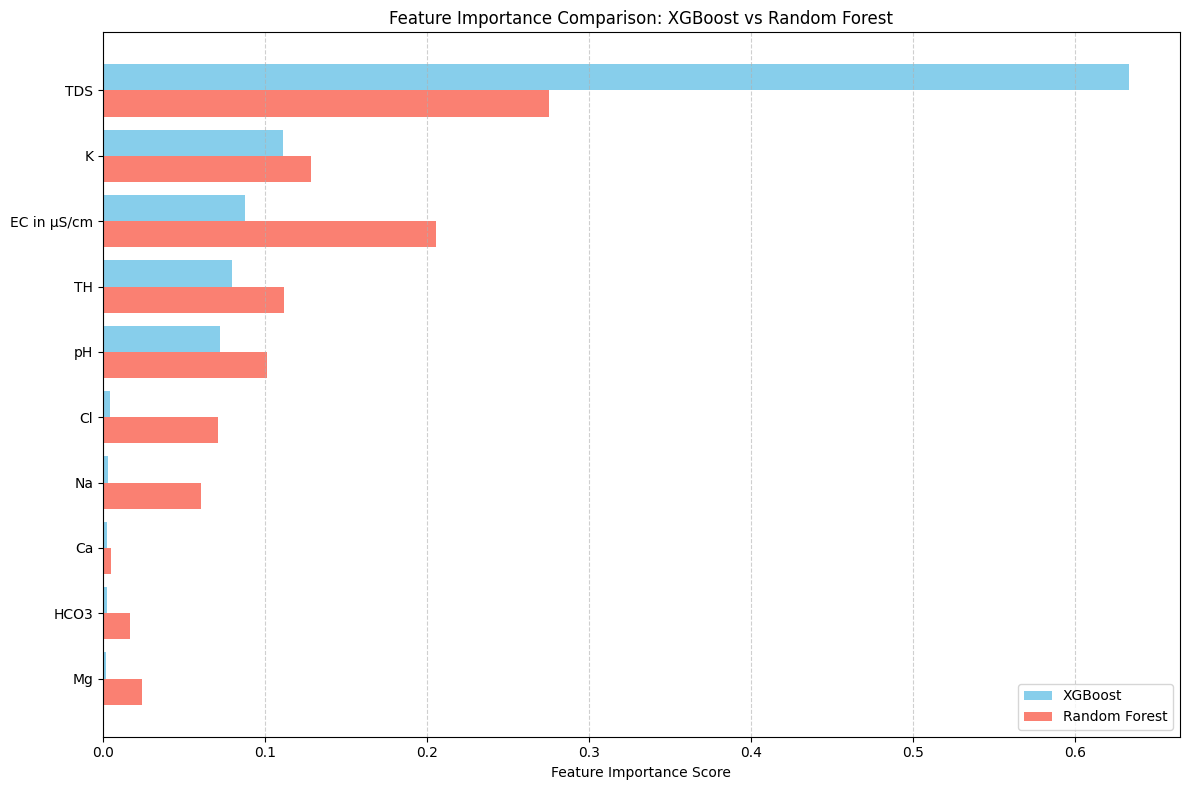

In [41]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12, 8))

# Number of features
num_features = len(feature_importance)

# Plot XGBoost importance
plt.barh(
    y=np.arange(num_features) - 0.2,
    width=feature_importance['XGBoost Importance'],
    height=0.4,
    label='XGBoost',
    color='skyblue'
)

# Plot Random Forest importance
plt.barh(
    y=np.arange(num_features) + 0.2,
    width=feature_importance['Random Forest Importance'],
    height=0.4,
    label='Random Forest',
    color='salmon'
)

# Set y-axis ticks and labels
plt.yticks(np.arange(num_features), feature_importance['Feature'])
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance Comparison: XGBoost vs Random Forest')
plt.legend()
plt.gca().invert_yaxis()  # Most important on top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [43]:
!pip install contextily
import contextily as ctx

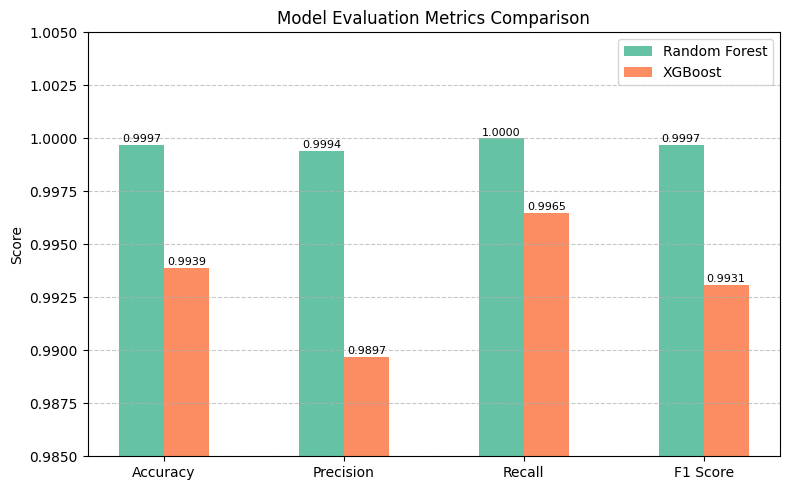

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
rf_scores = [0.9997, 0.9994, 1.0000, 0.9997]
xgb_scores = [0.9939, 0.9897, 0.9965, 0.9931]

x = np.arange(len(metrics))  # Label locations
width = 0.25  # Width of the bars (reduced for tighter spacing)

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, rf_scores, width, label='Random Forest', color='#66c2a5')
bars2 = ax.bar(x + width/2, xgb_scores, width, label='XGBoost', color='#fc8d62')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_title('Model Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim([0.985, 1.005])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 2), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.show()


In [48]:
import pandas as pd

# Load the CSV data
df = pd.read_csv("")
df.head()


FileNotFoundError: [Errno 2] No such file or directory: ''

In [56]:
import pandas as pd

data = pd.read_csv("/content/water_quality_data .csv")
print(data.columns)


Index(['Unnamed: 0', 'S. No.', 'State', 'District', 'Block', 'Village',
       'Latitude', 'Longitude', 'Year', 'pH', 'EC in μS/cm', 'HCO3', 'Cl',
       'TH', 'Ca', 'Mg', 'Na', 'K', 'TDS'],
      dtype='object')


Assessing water quality...

Top 5 Districts with Cleanest Water:
                 count  clean_percent
District                             
Nainital            19          100.0
Pauri Garhwal        3          100.0
Maharajganj         11          100.0
Kondagaon            3          100.0
Lakhimpur Khiri     15          100.0

Bottom 5 Districts with Poorest Water Quality:
                 count  clean_percent
District                             
Barnala              3            0.0
Bangalore Rural      7            0.0
Tumkur              18            0.0
BUNDI                9            0.0
BIKANER             24            0.0


TypeError: '>=' not supported between instances of 'str' and 'int'

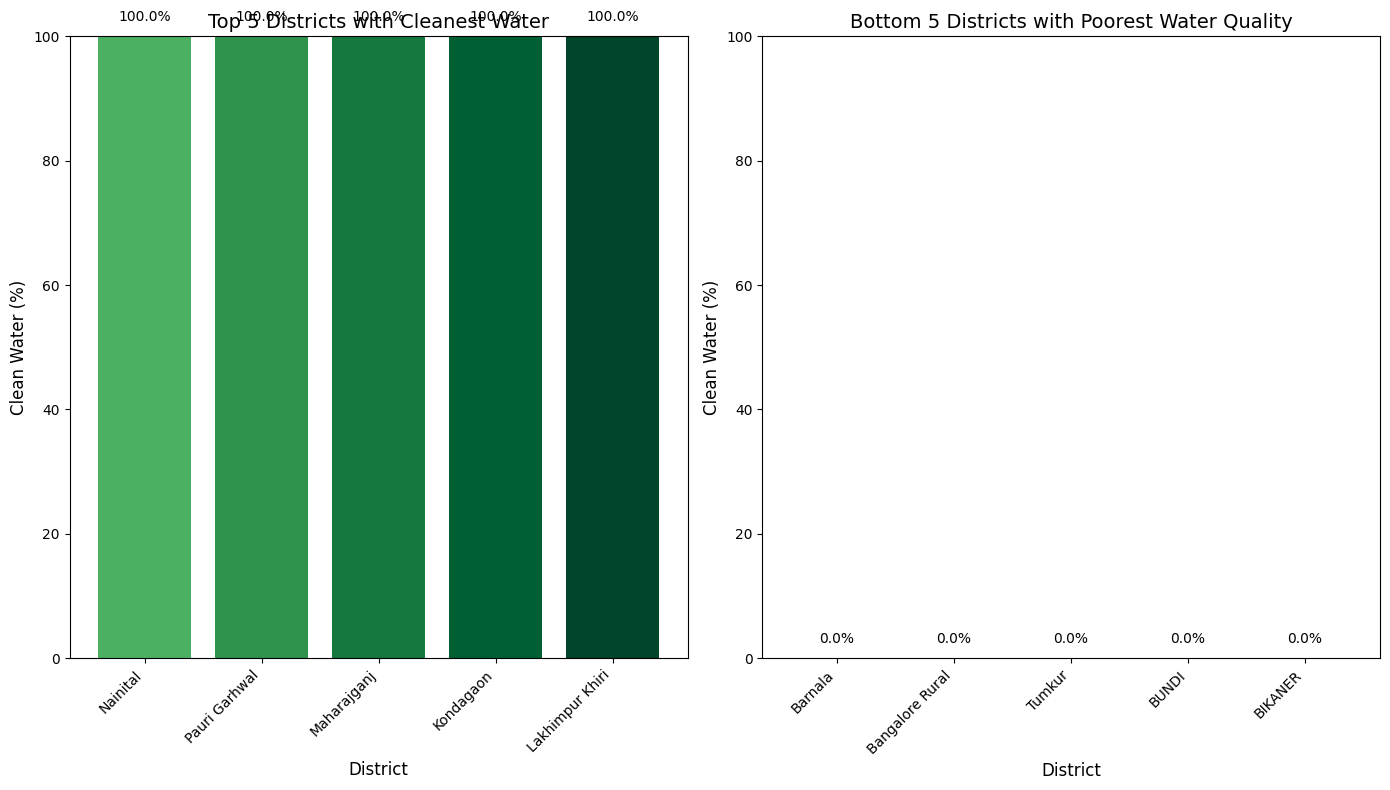

In [57]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import os
import numpy as np

# Load the data
# Adjust path if needed
data_path = "data/water_quality_data.csv"
if not os.path.exists(data_path):
    data_path = "water_quality_data.csv"  # Try current directory

data = pd.read_csv('/content/water_quality_data .csv')

# Define water quality rule (using WHO standards from the main script)
def assess_quality(row):
    try:
        if (
            6.5 <= row['pH'] <= 8.5 and
            row['TDS'] <= 500 and
            row['Cl'] <= 250 and
            row['TH'] <= 300 and
            row['Na'] <= 200 and
            row['K'] <= 12
        ):
            return 1  # Clean/Potable
        else:
            return 0  # Unhealthy/Non-potable
    except KeyError:
        # If any key is missing, default to 0
        return 0

print("Assessing water quality...")
# Apply rule to create a 'Prediction' column
data['Prediction'] = data.apply(assess_quality, axis=1)

# Group by district and calculate percentage of clean water samples
district_stats = data.groupby('District')['Prediction'].agg(['count', 'mean'])
district_stats['clean_percent'] = district_stats['mean'] * 100
district_stats = district_stats.sort_values('clean_percent', ascending=False)

# Get top 5 cleanest and bottom 5 worst districts (with sufficient samples)
min_samples = 3  # Minimum sample threshold for reliability
reliable_districts = district_stats[district_stats['count'] >= min_samples]

if len(reliable_districts) >= 10:  # Make sure we have enough districts
    top_districts = reliable_districts.head(5)
    bottom_districts = reliable_districts.tail(5)

    print("\nTop 5 Districts with Cleanest Water:")
    print(top_districts[['count', 'clean_percent']])

    print("\nBottom 5 Districts with Poorest Water Quality:")
    print(bottom_districts[['count', 'clean_percent']])

    # Create bar charts
    plt.figure(figsize=(14, 8))

    # Top districts
    ax1 = plt.subplot(121)
    colors = plt.cm.YlGn(np.linspace(0.6, 1, len(top_districts)))
    bars = ax1.bar(top_districts.index, top_districts['clean_percent'], color=colors)
    ax1.set_title('Top 5 Districts with Cleanest Water', fontsize=14)
    ax1.set_xlabel('District', fontsize=12)
    ax1.set_ylabel('Clean Water (%)', fontsize=12)
    ax1.set_ylim(0, 100)
    plt.xticks(rotation=45, ha='right')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%', ha='center', va='bottom')

    # Bottom districts
    ax2 = plt.subplot(122)
    colors = plt.cm.YlOrRd(np.linspace(0.6, 1, len(bottom_districts)))
    bars = ax2.bar(bottom_districts.index, bottom_districts['clean_percent'], color=colors)
    ax2.set_title('Bottom 5 Districts with Poorest Water Quality', fontsize=14)
    ax2.set_xlabel('District', fontsize=12)
    ax2.set_ylabel('Clean Water (%)', fontsize=12)
    ax2.set_ylim(0, 100)
    plt.xticks(rotation=45, ha='right')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%', ha='center', va='bottom')

    plt.tight_layout()

    # Create a map if we have coordinates
    if 'Latitude' in data.columns and 'Longitude' in data.columns:
        # Filter for districts with valid coordinates
        valid_coords = data.dropna(subset=['Latitude', 'Longitude'])
        valid_coords = valid_coords[
            (valid_coords['Latitude'] >= 0) &
            (valid_coords['Latitude'] <= 90) &
            (valid_coords['Longitude'] >= 0) &
            (valid_coords['Longitude'] <= 180)
        ]

        # Filter for our selected districts
        selected_districts = list(top_districts.index) + list(bottom_districts.index)
        district_data = valid_coords[valid_coords['District'].isin(selected_districts)]

        # Create a basic map with points
        plt.figure(figsize=(12, 10))

        # Create a background with all points
        plt.scatter(valid_coords['Longitude'], valid_coords['Latitude'],
                  color='lightgray', s=10, alpha=0.3)

        # Calculate average coordinates for each district for labeling
        for district in top_districts.index:
            district_samples = valid_coords[valid_coords['District'] == district]
            if len(district_samples) > 0:
                avg_lon = district_samples['Longitude'].mean()
                avg_lat = district_samples['Latitude'].mean()
                plt.scatter(avg_lon, avg_lat, s=150, color='green', edgecolor='black', alpha=0.7)
                plt.text(avg_lon, avg_lat+0.2, district, fontsize=9, ha='center',
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle="round,pad=0.3"))

        for district in bottom_districts.index:
            district_samples = valid_coords[valid_coords['District'] == district]
            if len(district_samples) > 0:
                avg_lon = district_samples['Longitude'].mean()
                avg_lat = district_samples['Latitude'].mean()
                plt.scatter(avg_lon, avg_lat, s=150, color='red', edgecolor='black', alpha=0.7)
                plt.text(avg_lon, avg_lat+0.2, district, fontsize=9, ha='center',
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle="round,pad=0.3"))

        # Add a legend
        clean_patch = mpatches.Patch(color='green', alpha=0.7, label='Top 5 Districts (Cleanest Water)')
        poor_patch = mpatches.Patch(color='red', alpha=0.7, label='Bottom 5 Districts (Poorest Water)')
        bg_patch = mpatches.Patch(color='lightgray', alpha=0.3, label='Other Locations')
        plt.legend(handles=[clean_patch, poor_patch, bg_patch], loc='upper right')

        plt.title('Districts with Best and Worst Water Quality', fontsize=16)
        plt.xlabel('Longitude', fontsize=12)
        plt.ylabel('Latitude', fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
    else:
        print("Cannot create map: Latitude and Longitude columns not found")
else:
    print(f"Not enough districts with sufficient data. Found {len(reliable_districts)} districts with {min_samples}+ samples.")

In [54]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Convert Latitude and Longitude to numeric values
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Drop rows with missing coordinates
df = df.dropna(subset=['Latitude', 'Longitude'])

# Group by District and calculate average TDS
district_tds = df.groupby('District')['TDS'].mean().sort_values()

# Select two cleanest and two most unhealthy districts
cleanest_districts = district_tds.head(2).index.tolist()
unhealthy_districts = district_tds.tail(2).index.tolist()

# Filter original DataFrame
selected_districts = df[df['District'].isin(cleanest_districts + unhealthy_districts)]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    selected_districts,
    geometry=gpd.points_from_xy(selected_districts['Longitude'], selected_districts['Latitude']),
    crs="EPSG:4326"
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color=gdf['District'].apply(lambda x: 'green' if x in cleanest_districts else 'red'), markersize=50)
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['District']):
    ax.text(x + 0.05, y + 0.05, label, fontsize=9)

ax.set_title("Cleanest (Green) and Unhealthy (Red) Water Districts in Rajasthan", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.show()

NameError: name 'df' is not defined

In [55]:
print(data.columns)
print(data.head())


Index(['Unnamed: 0', 'S. No.', 'State', 'District', 'Block', 'Village',
       'Latitude', 'Longitude', 'Year', 'pH', 'EC in μS/cm', 'HCO3', 'Cl',
       'TH', 'Ca', 'Mg', 'Na', 'K', 'TDS', 'Prediction'],
      dtype='object')
   Unnamed: 0  S. No.      State     District       Block        Village  \
0           0      73  Rajasthan   GANGANAGAR    KARANPUR  Sunderpura_Pz   
1           1      74  Rajasthan  HANUMANGARH   SANGARIYA      RATANPURA   
2           2      75  Rajasthan   GANGANAGAR   SANGARIYA      KHERUWALA   
3           3      76  Rajasthan  HANUMANGARH   SANGARIYA      BOLANWALI   
4           4      77  Rajasthan   GANGANAGAR  GANGANAGAR       CHUNAWAD   

  Latitude Longitude  Year    pH  EC in μS/cm   HCO3    Cl     TH    Ca  \
0   30.029    73.665  2019  8.10        275.0  132.0  38.0  170.0  47.0   
1    29.85     74.45  2019  8.45       1110.0  364.0  60.0  165.0  43.0   
2   29.846    74.242  2019  7.96        300.0  120.0  52.0  130.0  39.0   
3   29.838     7